In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

lasu_df = pd.read_csv("../../Data/LASU_processed.csv")
print("Shape:", lasu_df.shape)
lasu_df.head()

# Check target column for missing values
print(lasu_df['admitted_numeric'].isna().sum())

# Drop rows with missing targets
lasu_df = lasu_df.dropna(subset=['admitted_numeric'])

# Define feature (X) and target (Y)
X = lasu_df[['utme_score', 'screening_score', 'faculty', 'department',
             'olevel_passed', 'olevel_avg_points']]
y = lasu_df['admitted_numeric']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Preprocessing (OneHotEncode categorical features)
categorical_features = ['faculty', 'department']
numeric_features = ['utme_score', 'screening_score',
                    'olevel_passed', 'olevel_avg_points']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

Shape: (10000, 7)
0
Train size: (8000, 6) Test size: (2000, 6)


In [ ]:
# Cell 5: Logistic Regression (Baseline Model)
log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', LogisticRegression(max_iter=200))])

LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.992

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1013
           1       0.99      0.99      0.99       987

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Decision Tree
decision_tree = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', DecisionTreeClassifier(max_depth=8, random_state=42))])

decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1013
           1       1.00      1.00      1.00       987

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
# Random Forest
import os
import joblib
random_forest = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', RandomForestClassifier(n_estimators=200, random_state=42))])

random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


os.makedirs("../../Models", exist_ok=True)

joblib.dump(random_forest, "../../Models/lasu_admission_model.pkl")
print("Model saved successfully!")

Random Forest Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1013
           1       1.00      1.00      1.00       987

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Model saved successfully!


In [ ]:
# Stacking Ensemble (Decision Tree + Random Forest)
base_estimators = [
    ('dt', DecisionTreeClassifier(max_depth=8, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
]

stacking_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', StackingClassifier(
                                     estimators=base_estimators,
                                     final_estimator=LogisticRegression(
                                         max_iter=200),
                                     cv=5
                                 ))])

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

Stacking Ensemble Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1013
           1       1.00      1.00      1.00       987

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



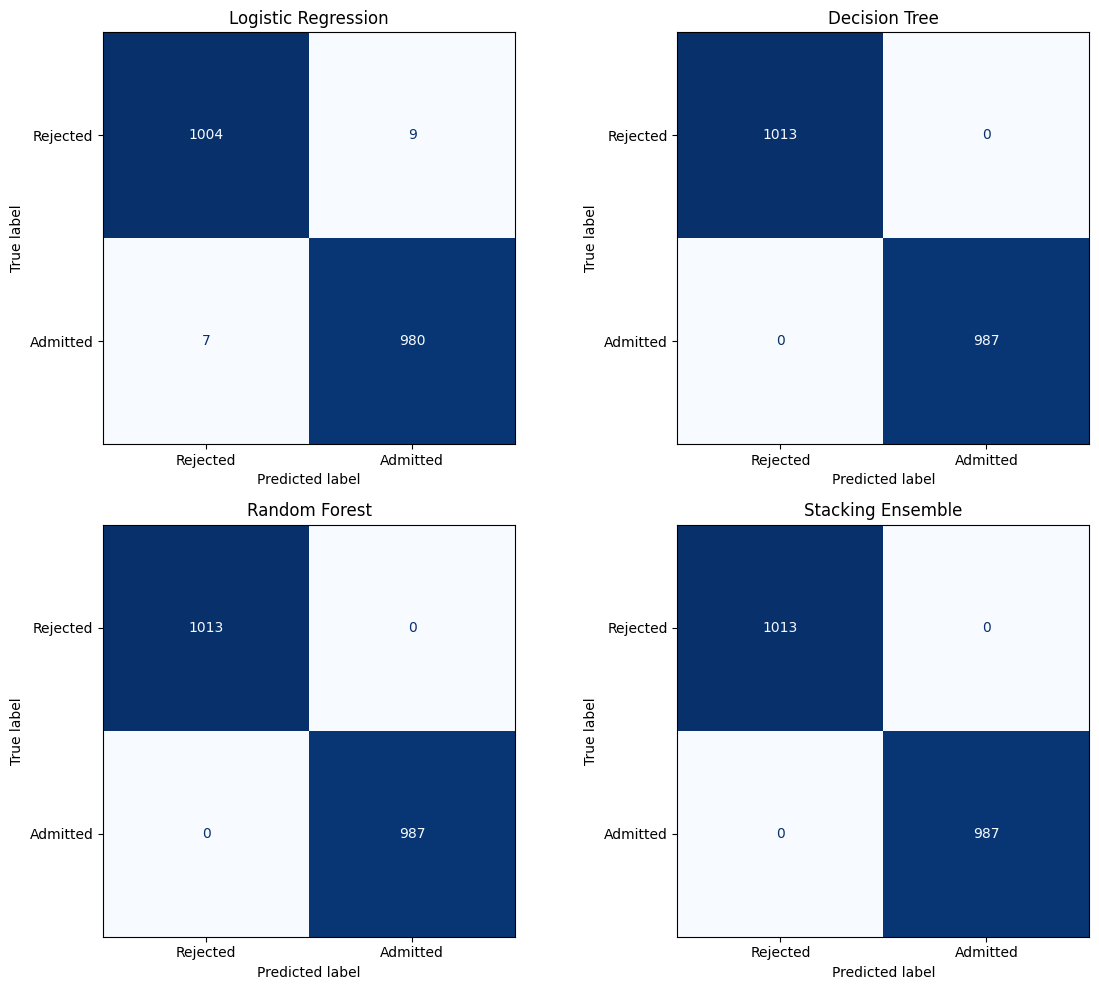

In [ ]:
# Confusion Matrix Comparison
from sklearn.metrics import ConfusionMatrixDisplay

models = {
    "Logistic Regression": y_pred_lr,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Stacking Ensemble": y_pred_stack
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, preds) in zip(axes, models.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, preds), display_labels=["Rejected", "Admitted"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_6492\2335814098.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(15), x="Importance", y="Feature", palette="viridis")


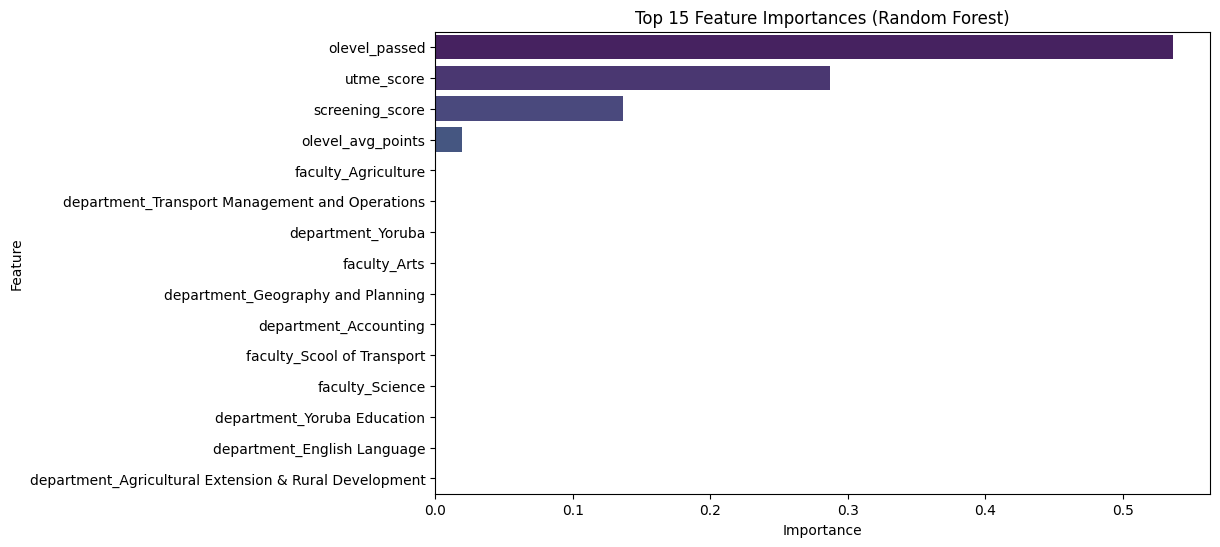

In [ ]:
# Feature Importance (from Random Forest)
# Extract feature importance from Random Forest model
rf_model = random_forest.named_steps['model']
ohe = random_forest.named_steps['preprocessor'].named_transformers_['cat']
encoded_cats = ohe.get_feature_names_out(categorical_features)

feature_names = list(encoded_cats) + numeric_features
importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(15), x="Importance",
            y="Feature", palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()